In [1]:
from experimental.moons_t import moon_task
import optax
from experimental.breastcancer_t import breast_task

opts = [optax.sgd(0.005), optax.adam(0.0025), optax.noisy_sgd(0.005, 0.001, 0.75), optax.adamw(0.001)]
val_accs = []
test_accs = []

for key in [42,43,44, 45, 46]:
    temp = []
    test = []
    for idx, opt in enumerate(opts):
        task = moon_task(state=key)
        test_acc, vals = task.train(opt)
        temp.append(vals)
        test.append(test_acc)

    val_accs.append(temp)
    test_accs.append(test)

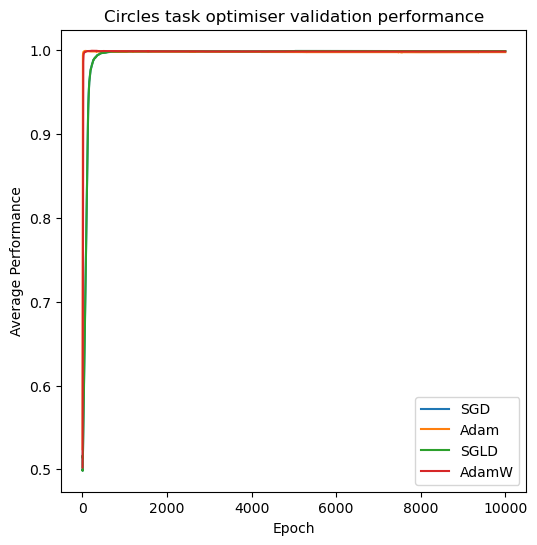

In [7]:
import matplotlib.pyplot as plt
import numpy as np

vals_np = np.array(val_accs)


# Compute the column-wise mean
column_means = vals_np.mean(axis=0)
std = vals_np.std(axis=0)

# Create plot
plt.figure(figsize=(6, 6))

# Assuming the x-axis represents the epochs
epochs = np.arange(1, 10001)  # or whatever the number of epochs/steps is

# Assuming the optimizers are as follows
optimizers = ['SGD', 'Adam', 'SGLD', 'AdamW']

for idx, optimizer in enumerate(optimizers):
    plt.plot(epochs, column_means[idx], label=optimizer)
    #plt.fill_between(epochs, column_means[idx] - std[idx], column_means[idx] + std[idx], alpha=0.2)

# for idx, optimizer in enumerate(optimizers):
#     plt.plot(epochs[1000:], column_means[idx][1000:], label=optimizer)
#     plt.fill_between(epochs[1000:], column_means[idx][1000:] - std[idx][1000:], column_means[idx][1000:] + std[idx][1000:], alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Average Performance')
plt.title('Circles task optimiser validation performance')
plt.legend()

plt.show()

In [55]:
import jax
import jax.numpy as jnp
from jax import random

class SGLDOptimizer:
    def __init__(self, step_size, noise_scale, key=random.PRNGKey(0)):
        self.step_size = step_size
        self.noise_scale = noise_scale
        self.key = key

    def step(self, grads, params):
        noise = random.normal(self.key, params.shape) * self.noise_scale
        self.key, _ = random.split(self.key)
        return params - self.step_size * grads + noise

    def update(self, params, grads):
        return self.step(params, grads)

    def init(self, filler):
        pass

In [88]:
import math
import jax
import jax.numpy as jnp
import optax
import numpy as np

# Define the function
def f(x):
    #v, w = x[0], x[1]
    #v = x[0]
    w1 = 1 + (x[0] - 1) / 4
    w2 = 1 + (x[1] - 1) / 4
    term1 = jnp.sin(jnp.pi * w1) ** 2
    term2 = (w2 - 1) ** 2 * (1 + 10 * (jnp.sin(jnp.pi * w2 + 1) ** 2))
    term3 = (w2 - 1) ** 2 * (1 + jnp.sin(2 * jnp.pi * w2) ** 2)
    return term1 + term2 + term3
    #return jnp.log(v**2 + 16 + 0.5)**2 + jnp.abs(jnp.sin(v - 4)) - 9
    #return -(-jnp.sin(3 * v) - v ** 2 + 0.7 * v)
    #return v**2 - 10*jnp.cos(2*jnp.pi*v) + 10
    #return(v + 2*w - 7)**2 + (2*v + w - 5)**2
    #return jnp.sin(3*jnp.pi*v) + (v - 1)**2 * (1+jnp.sin(3*jnp.pi*w)**2) + (w-1)**2 * (1 + jnp.sin(2*jnp.pi*w)**2)
    #return 100 * (w - v**2)**2 + (1 - v)**2


# Compute the gradient of the function
grad_f = jax.grad(f)

# Initialize v
# Create a random key
opts = [optax.sgd(0.005), optax.adam(0.005), optax.noisy_sgd(0.005, 0.001, 0.75), optax.adamw(0.005), SGLDOptimizer(step_size=0.01, noise_scale=0.1)]
#opts = [SGLDOptimizer(step_size=0.0001, noise_scale=0.5)]
means = []
stds = []
for idx, opt in enumerate(opts):
    fs = []
    for i in range(10):
        key = jax.random.PRNGKey(i)

        # Initialize v as a random value from a normal distribution
        v = jax.random.normal(key, [2], dtype=jnp.float64)
        # Create an Adam optimizer
        optimizer = opt

        # Initialize optimizer state
        state = optimizer.init(v)

        # Optimization loop for 1000 iterations

        minima = math.inf
        min_v = 0
        for i in range(3000):
            g = grad_f(v)
            if idx == len(opts) - 1:
                v = opt.update(g, v)
            else:
                updates, state = optimizer.update(g, state, params=v)
                v = optax.apply_updates(v, updates)
            if f(v) < minima:
                minima = f(v)
                min_v = v
            if i % 100 == 0:
                print(f"Iteration {i}, v: {v}, f(v): {f(v)}")

        if math.isnan(v[0].item()):
            print("NAAANNNN ALERT")
        else:
            fs.append(minima)


        print(minima)
        print(min_v)

    print(np.mean(fs))
    print(np.std(fs))

    means.append(np.mean(fs))
    stds.append(np.std(fs))

print(means)
print(stds)



Iteration 0, v: [-0.7834634  0.857123 ], f(v): 0.9816462993621826
Iteration 100, v: [-0.6083488  0.9127604], f(v): 0.9123514890670776
Iteration 200, v: [-0.32326275  0.9483057 ], f(v): 0.7445741891860962
Iteration 300, v: [0.05425153 0.9699416 ], f(v): 0.4579429626464844
Iteration 400, v: [0.41460052 0.9827197 ], f(v): 0.19707553088665009
Iteration 500, v: [0.66800153 0.9901316 ], f(v): 0.0665188580751419
Iteration 600, v: [0.81823313 0.99438596], f(v): 0.020259998738765717
Iteration 700, v: [0.9016197 0.9968132], f(v): 0.005964152980595827
Iteration 800, v: [0.94693553 0.9981935 ], f(v): 0.0017377890180796385
Iteration 900, v: [0.971407  0.9989766], f(v): 0.000504816765896976
Iteration 1000, v: [0.98459786 0.9994203 ], f(v): 0.00014651601668447256
Iteration 1100, v: [0.9917041  0.99967176], f(v): 4.2514300730545074e-05
Iteration 1200, v: [0.99553156 0.9998142 ], f(v): 1.2335651263128966e-05
Iteration 1300, v: [0.9975932  0.99989474], f(v): 3.579658596208901e-06
Iteration 1400, v: [0.9

In [85]:
w, v = 1.17, 2.52
print(jnp.sin(3*jnp.pi*v) + (v - 1)**2 * (1+jnp.sin(3*jnp.pi*w)**2) + (w-1)**2 * (1 + jnp.sin(2*jnp.pi*w)**2))

3.6873262


In [86]:
def levy_2d(x, y):
    w1 = 1 + (x - 1) / 4
    w2 = 1 + (y - 1) / 4
    term1 = np.sin(np.pi * w1) ** 2
    term2 = (w2 - 1) ** 2 * (1 + 10 * (np.sin(np.pi * w2 + 1) ** 2))
    term3 = (w2 - 1) ** 2 * (1 + np.sin(2 * np.pi * w2) ** 2)
    return term1 + term2 + term3

print(levy_2d(1,1))

1.4997597826618576e-32
